<a href="https://colab.research.google.com/github/tewei0328/trade-backtest/blob/main/backtrader4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [量化投資] 運用python量化投資平台backtrader 實現ETF動量資產配置回測
https://ithelp.ithome.com.tw/articles/10284020?sc=pt

In [1]:
!pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 7.2 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
-------data1----------------
TW006208 size: 5623
TW006208 price: 79.28704378838442
-------data2----------------
TW00895 size: 27456
TW00895 price: 17.411837606338032


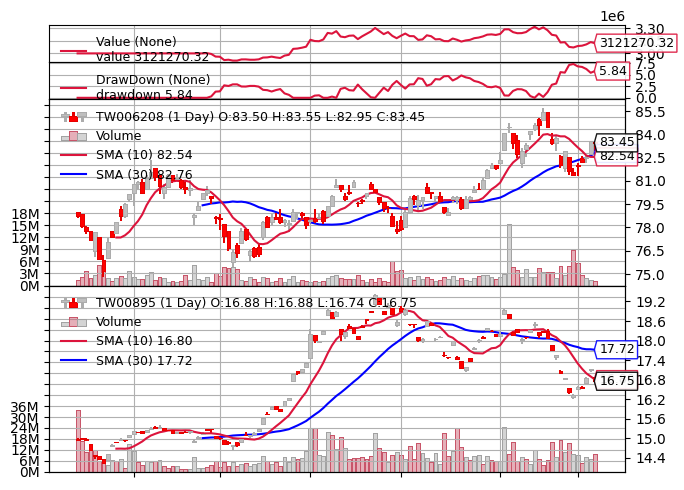

value: 3121270.3242702484
cash: 2192142.9914302826


In [2]:
import yfinance as yf 
import backtrader as bt
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd

#輸入資料
tw006208 = yf.Ticker('006208.TW')
df1=yf.download('006208.TW',start='2021-08-12',end='2022-2-14')
df1 = df1[['Open','High','Low','Close','Volume']]
df1.index= pd.to_datetime(df1.index)
df1.columns=['open','high','low','close','volume']
df1.fillna(0)
df1.to_csv('TW006208.csv')

tw00895 = yf.Ticker('00895.TW')
df2=yf.download('00895.TW',start='2021-08-12',end='2022-2-14')
df2 = df2[['Open','High','Low','Close','Volume']]
df2.index= pd.to_datetime(df2.index)
df2.columns=['open','high','low','close','volume']
df2.fillna(0)
df2.to_csv('TW00895.csv')


#創建策略：
class Sma_double_line(bt.SignalStrategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        self.d0_sma1 = bt.ind.SMA(self.data0.close,period=self.p.pfast)  # data0 fast moving average
        self.d0_sma2 = bt.ind.SMA(self.data0.close,period=self.p.pslow)  # data0 slow moving average
        
        self.d1_sma1 = bt.ind.SMA(self.data1.close,period=self.p.pfast)  # data0 fast moving average
        self.d1_sma2 = bt.ind.SMA(self.data1.close,period=self.p.pslow)  # data0 slow moving average       
        
        #crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal
        

    def next(self):
             
        if  self.d0_sma1[0] > self.d0_sma2[0] and  self.d1_sma1 > self.d1_sma2[0] :
            self.order_target_percent(target=0.5,data='TW006208') 
            self.order_target_percent(target=0.5,data='TW00895')             
                   
        if  self.d0_sma1[0] < self.d0_sma2[0] and  self.d1_sma1 < self.d1_sma2[0] :
            self.order_target_percent(target=0.15,data='TW006208') 
            self.order_target_percent(target=0.15,data='TW00895')   
            
        if  self.d0_sma1[0] > self.d0_sma2[0] and  self.d1_sma1 < self.d1_sma2[0] :
            self.order_target_percent(target=0.5,data='TW006208') 
            self.order_target_percent(target=0.15,data='TW00895')   
    
        if  self.d0_sma1[0] < self.d0_sma2[0] and  self.d1_sma1 > self.d1_sma2[0] :
            self.order_target_percent(target=0.15,data='TW006208') 
            self.order_target_percent(target=0.5,data='TW00895') 

#backtrader cerebro ：

if __name__ == '__main__':
    cerebro = bt.Cerebro(stdstats=False)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    
    datafeed1 = bt.feeds.PandasData(dataname=df1,name='TW006208')
    datafeed2 = bt.feeds.PandasData(dataname=df2,name='TW00895')
    cerebro.adddata(datafeed1)
    cerebro.adddata(datafeed2)
    cerebro.addstrategy(Sma_double_line)
    cerebro.addsizer(bt.sizers.AllInSizer,percents=99)
    cerebro.broker.setcash(3000000)
    cerebro.run()
    pos1 = cerebro.broker.getposition(datafeed1)
    pos2 = cerebro.broker.getposition(datafeed2)
    
    print('-------data1----------------')
    print('TW006208 size:', pos1.size)
    print('TW006208 price:', pos1.price)
    
    print('-------data2----------------')
    print('TW00895 size:', pos2.size)
    print('TW00895 price:', pos2.price) 
    cerebro.plot(iplot=False,style='candlestick')
    
    print('value:', cerebro.broker.get_value())
    print('cash:', cerebro.broker.get_cash())